A simple illustration of geographic map drawing using R libraries.

<br>

## Preliminaries

In [1]:
setwd(base::dirname(getwd()))

<br>
<br>

### Libraries

In [ ]:
.activate <- function (x){
    library(x, character.only = TRUE, quietly = TRUE, warn.conflicts = FALSE, verbose = FALSE)
    if (x == 'rmarkdown') {library(tinytex)}
}
packages <- c('tmap', 'sf', 'magrittr', 'tidyr', 'dplyr', 'tibble', 'ggplot2', 'stringr')
lapply(X = packages, .activate)

<br>
<br>

## Onchocerciasis in Liberia

### A Field Data Set

Reading-in a sample data set; a Liberia *onchocerciasis*, i.e., river blindness, data set.

In [3]:
frame <- read.csv(file = 'data/sample/sample.csv')

<br>

A preview of the data set.  Each record represents a location, therefore  `lat` & `long` are a location's latitude & longitude co&ouml;rdinates, respectively.  `ntest` is the the of onchocerciasis tests conducted at a location, whilst `npos` is the number of positive tests.  `elevation` is a location's elevation above sea level; metres. `X` is a record's unique identification number.

In [4]:
str(frame)

'data.frame':	90 obs. of  8 variables:
 $ X        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ lat      : num  6.29 6.57 6.57 6.73 6.02 ...
 $ long     : num  -10.5 -10.5 -10 -10.3 -10 ...
 $ ntest    : int  50 46 43 50 48 50 43 50 47 43 ...
 $ npos     : int  14 10 11 10 9 13 9 11 11 0 ...
 $ utm_x    : num  337051 338909 385902 357021 384698 ...
 $ utm_y    : num  695084 726563 725802 744298 664992 ...
 $ elevation: num  17.8 104.9 119.1 144.1 19 ...


<br>

The prevalence, `prev`.

In [5]:
frame$prev <- frame$npos / frame$ntest

<br>

Converting the data set to a geographic data set, and setting its reference co&ouml;rdinates system to Universal Transverse Mercator (UTM). The UTM code of Liberia is $32629$.

In [6]:
utm <- 32629
liberia <- st_as_sf(frame, coords = c('utm_x', 'utm_y'))
st_crs(liberia) <- utm

In [7]:
str(liberia)

Classes 'sf' and 'data.frame':	90 obs. of  8 variables:
 $ X        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ lat      : num  6.29 6.57 6.57 6.73 6.02 ...
 $ long     : num  -10.5 -10.5 -10 -10.3 -10 ...
 $ ntest    : int  50 46 43 50 48 50 43 50 47 43 ...
 $ npos     : int  14 10 11 10 9 13 9 11 11 0 ...
 $ elevation: num  17.8 104.9 119.1 144.1 19 ...
 $ prev     : num  0.28 0.217 0.256 0.2 0.188 ...
 $ geometry :sfc_POINT of length 90; first list element:  'XY' num  337051 695084
 - attr(*, "sf_column")= chr "geometry"
 - attr(*, "agr")= Factor w/ 3 levels "constant","aggregate",..: NA NA NA NA NA NA NA
  ..- attr(*, "names")= chr [1:7] "X" "lat" "long" "ntest" ...


<br>
<br>

### The Borders of Liberia

Reading-in the shape file of Liberia's country border.

In [8]:
liberia_border <- st_read(dsn = 'data/sample/liberia/LBR_adm/LBR_adm0.shp')
liberia_border <- st_transform(liberia_border, crs = utm)

Reading layer `LBR_adm0' from data source 
  `J:\library\premodelling\mapping\data\sample\liberia\LBR_adm\LBR_adm0.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 70 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -11.48569 ymin: 4.352916 xmax: -7.365113 ymax: 8.55179
Geodetic CRS:  WGS 84


<br>

The border outline of Liberia

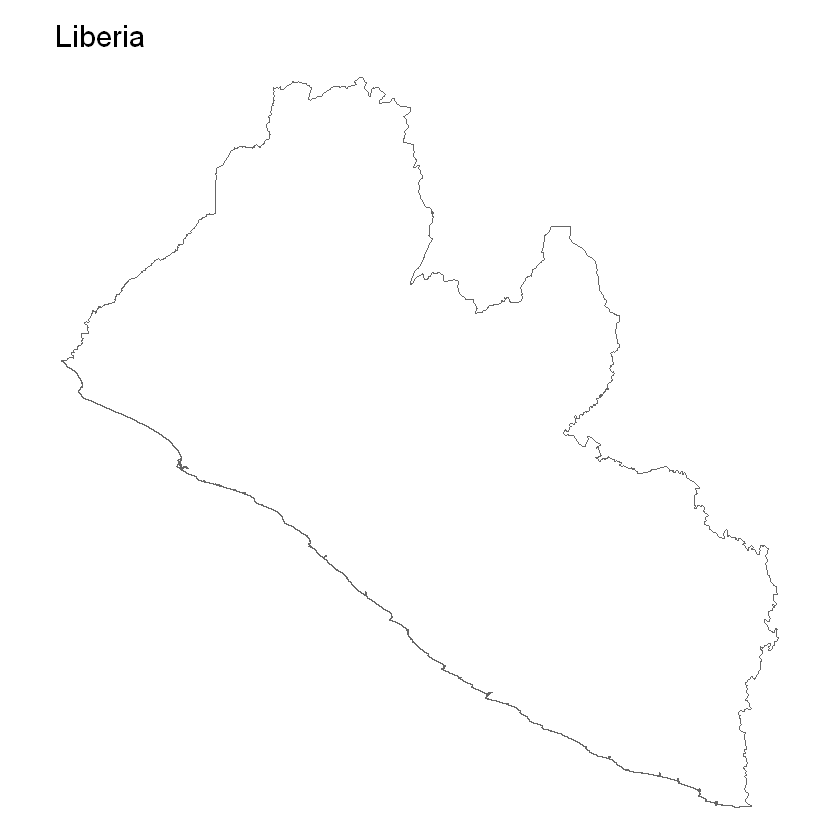

In [9]:
outline <- tm_shape(liberia_border) +
  tm_layout(main.title = 'Liberia', frame = FALSE) +
  tm_borders(lwd = 0.5)
outline

<br>
<br>

### Illustrating Onchocerciasis Prevalence in Liberia

Overlaying the co&ouml;rdinate points of `liberia` on the map `outline`, above.  The size of the co&ouml;rdinate points is proportional to the `prev` value at that point, i.e., the prevalence of onchocerciasis.

In [10]:
map <- outline +
  tm_shape(liberia) +
  tm_bubbles(size = 'prev', col = 'prev',
             border.col = 'white',
             border.alpha = 0,
             style = 'fixed',
             breaks = seq(0, 0.4, 0.1),
             palette = '-RdYlBu',
             title.size = 'Onchocerciasis Prevalence',
             scale = 1,
             title.col = '')

<br>

Positioning the legend, and adding a compass.

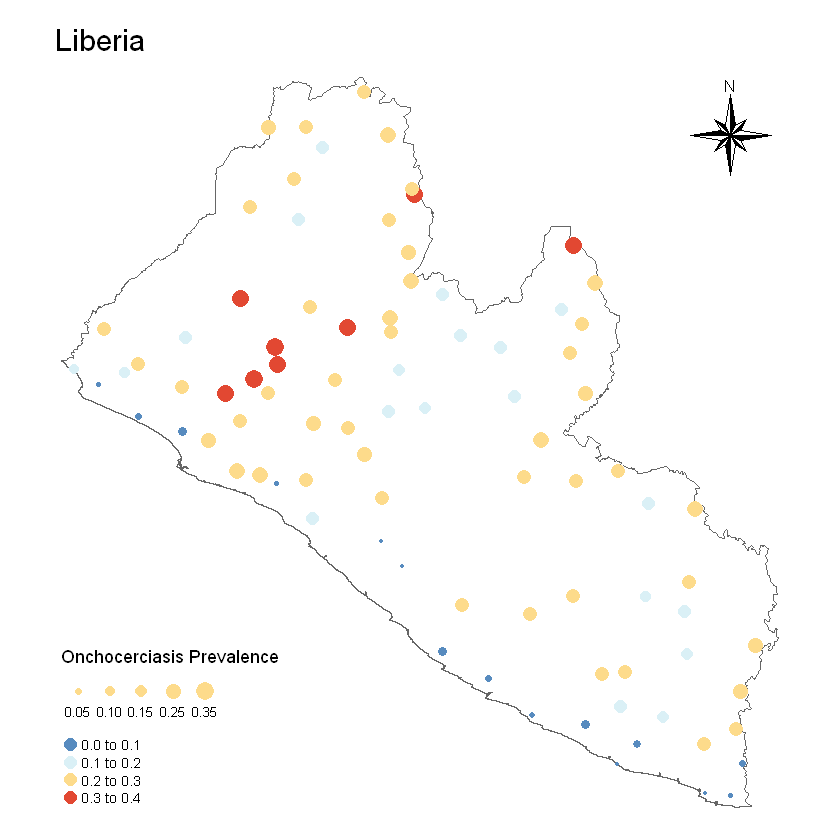

In [11]:
map +
  tm_layout(legend.position = c('left', 'bottom')) +
  tm_compass(type = '8star', position = c('right', 'top'))

<br>
<br>

## Onchocerciasis Prevalence & Elevation

### Elevations

Reading-in a raster map of altitudes.

In [12]:
liberia_altitude <- terra::rast('data/sample/liberia/LBR_alt/LBR_alt.vrt')
cat(class(x = liberia_altitude), '\n\n')
cat(terra::crs(liberia_altitude))

SpatRaster 

GEOGCRS["unknown",
    DATUM["Unknown based on WGS84 ellipsoid",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1],
            ID["EPSG",7030]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433],
        ID["EPSG",8901]],
    CS[ellipsoidal,2],
        AXIS["longitude",east,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["latitude",north,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]

<br>

Projecting to the UTM co&ouml;rdinate reference system (CRS); inline with the CRS of `liberia`.

In [13]:
liberia_altitude <- terra::project(liberia_altitude, paste0('EPSG:', utm), method = 'bilinear')

<br>

Additionally, trimming out extraneous terrains.

In [14]:
liberia_altitude <- terra::mask(liberia_altitude, terra::vect(liberia_border))

<br>

A preview of the raster of altitudes

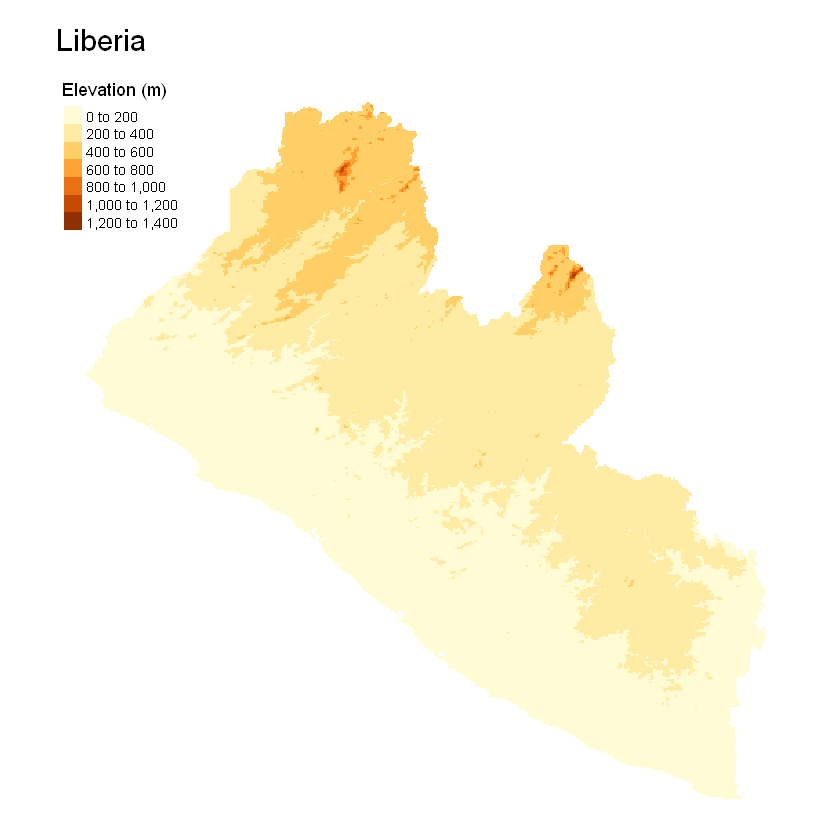

In [15]:
tmap::tm_shape(liberia_altitude) +
    tmap::tm_layout(main.title = 'Liberia', frame = FALSE) +
    tmap::tm_raster(title = 'Elevation (m)')

<br>

### Elevations Raster & Prevalence

In the diagram below, the size of each point is proportional to onchocerciasis prevavlece at that point.

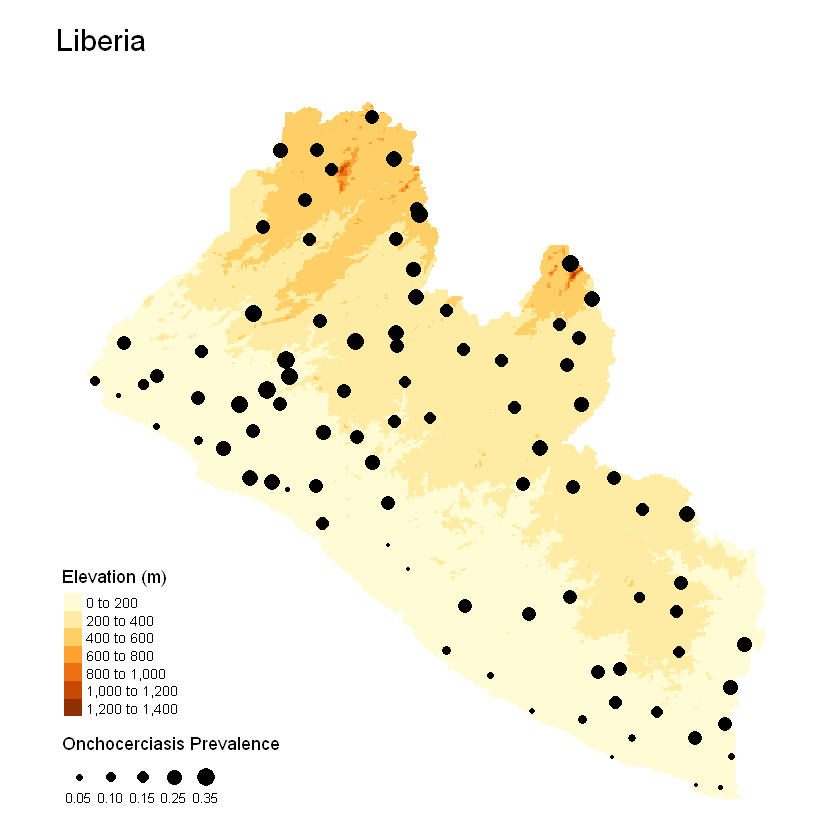

In [16]:
tmap::tm_shape(liberia_altitude) +
    tmap::tm_layout(main.title = 'Liberia', frame = FALSE) +
    tmap::tm_raster(title = 'Elevation (m)') + 
    tmap::tm_shape(liberia) + 
    tmap::tm_bubbles(size = 'prev', col = 'black',
             border.col = 'white',
             border.alpha = 0,
             style = 'fixed',
             breaks = seq(0, 0.4, 0.1),
             title.size = 'Onchocerciasis Prevalence',
             scale = 1,
             title.col = '') + 
    tmap::tm_layout(legend.position = c('left', 'bottom'))

<br>

### Elevation Values & Prevalence

The altitude value at a co&ouml;rdinate point can be extracted from an appropriate topographic raster.  `liberia` is the geographic form of the data frame `frame`, it is used to extract the elevation value per co&ouml;rdinate point in `frame`

In [17]:
frame$elevation <- terra::extract(liberia_altitude, terra::vect(liberia)) %>%
  dplyr::select(!ID) %>%
  unlist() %>%
  as.numeric()

In [18]:
str(frame)

'data.frame':	90 obs. of  9 variables:
 $ X        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ lat      : num  6.29 6.57 6.57 6.73 6.02 ...
 $ long     : num  -10.5 -10.5 -10 -10.3 -10 ...
 $ ntest    : int  50 46 43 50 48 50 43 50 47 43 ...
 $ npos     : int  14 10 11 10 9 13 9 11 11 0 ...
 $ utm_x    : num  337051 338909 385902 357021 384698 ...
 $ utm_y    : num  695084 726563 725802 744298 664992 ...
 $ elevation: num  17.9 101.1 119.5 150.3 20.4 ...
 $ prev     : num  0.28 0.217 0.256 0.2 0.188 ...


<br>
<br>

A graph of *prevalence* against *elevation*.  Note that `mar = c(bottom, left, top, right)`


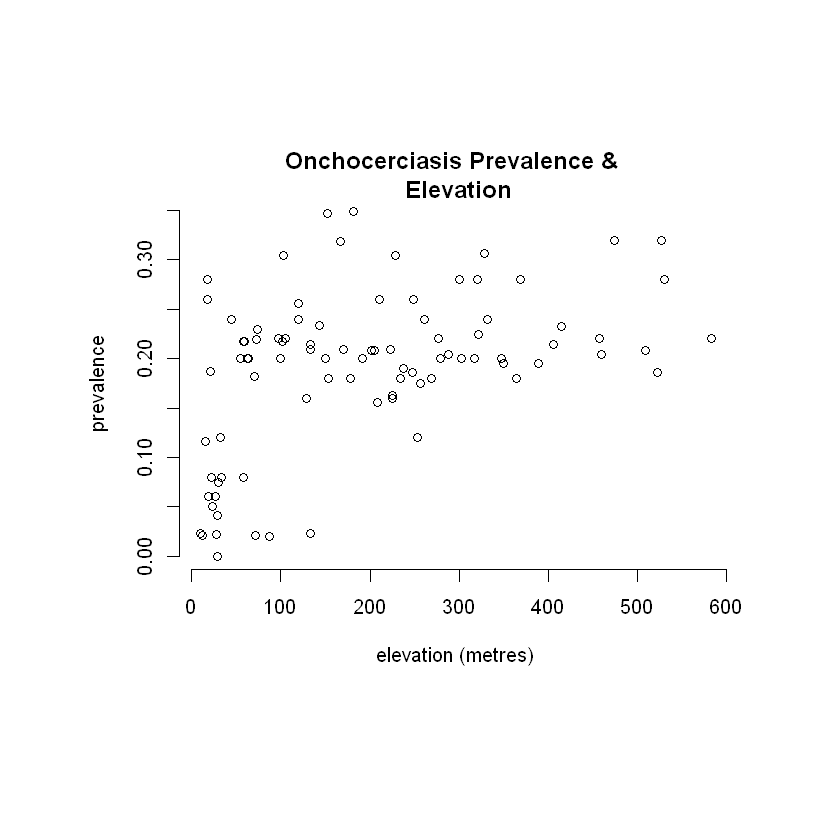

In [19]:
graphics::par(mar = c(5, 5, 2, 2), fin = c(6, 4.5))
plot(x = frame$elevation, y = frame$prev, frame.plot = FALSE, 
     xlab = 'elevation (metres)', ylab = 'prevalence', main = 'Onchocerciasis Prevalence & \n Elevation')